# Imports

#Accuracy score is informative metric for balanced datasets.

**Cat - 0**

**Dog - 1**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# df2 = pd.DataFrame(np.array([[1000, 400, 'rbf', 0.94, 0.77], [1000, 1000, 'rbf', 0.9675, 0.758]]),
#                    columns=['Features to detect', 'Clusters', 'SVM Kernel', 'Train accuracy', 'Validation accuracy'])

df3 = pd.read_csv('hyperparamsearch.csv')
# df3 = pd.concat([df2, df])

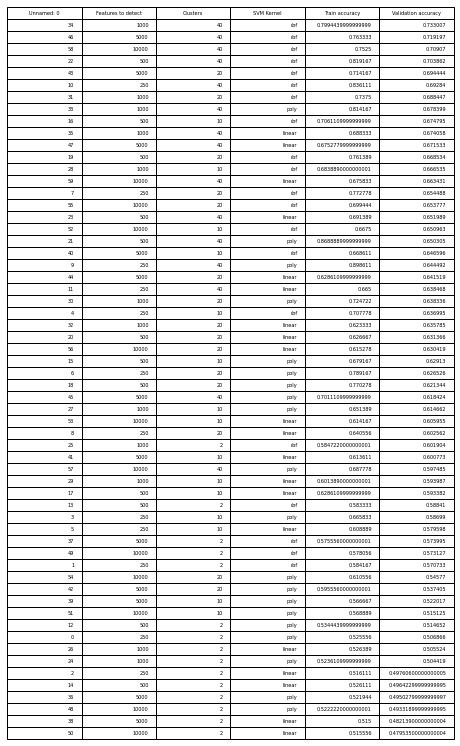

In [12]:
#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(8,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df3.values, colLabels=df3.columns, loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("hyperparamsearch.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [2]:
import cv2
import numpy as np
import os
import random
import pandas as pd
from skimage import io, transform
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score #sreeni
from scipy import signal

# Get dataset

In [3]:
# Label: cat == 0; dog == 1

# the number of cat/dog pics for each breed
NUM_CATS = [99, 98, 100, 100, 100, 92, 100, 100, 99, 100, 100, 100]
NUM_DOGS = [100 for i in range(12)]

In [4]:
# define a dataset class to streamline the training, validation and testing
# 3-fold cross validation
# A&B -> C, then repeat for A&C -> B and B&C -> A (according to an email from Bob)
# data is split into 3 equal parts: A, B, C
# training and validation set is split 75%/25%

class CatDogDataset:
    def __init__(self, root_dir, set_name, transform=None):
        # root directory of the dataset is usually '../catdog/'
        self.root_dir = root_dir
        # set_name is used to identify which part (A, B or C) is testing set
        # and determine the output of the dataset is training/validation/test
        self.set_name = set_name
        # apply transform if needed
        self.transform = transform
        
        # rng (random number generator) is used to generate random indices for part A, B and C
        # we use a seed to make sure the split is fixed in each run
        rng = np.random.RandomState(seed=0)
        
        # initialise empty lists to store names for different image sets
        # we will use the names of images to retrieve images later
        cat_A, cat_B, cat_C, dog_A, dog_B, dog_C = [], [], [], [], [], []
        
        # we use for loop to sample images from each breed of dogs and cats
        # to make sure set A, B and C have the same data distribution
        for b in range(1, 13):
            
            # here we sample image indices for each breed
            # for each breed (around 100 images), sample 66 images for set catA and catB
            catAncatB = rng.choice(a=[i for i in range(NUM_CATS[b-1])], size=66, replace=False)
            
            # catA samples 33 images from combined catAncatB set
            catA = rng.choice(a=catAncatB, size=33, replace=False)
            
            # the rest of images in combined catAncatB set will go to catB
            catB = [i for i in catAncatB if i not in catA]
            
            # the rest of images in the original set will go to catC
            catC = [i for i in range(NUM_CATS[b-1]) if i not in catAncatB]
            
            # use the image indices to build the name/path of the images in each set
            # 0 is the label for cats
            cat_A += [['CATS/cat_'+str(b)+'_'+str(i)+'.png', 0] for i in catA]
            cat_B += [['CATS/cat_'+str(b)+'_'+str(i)+'.png', 0] for i in catB]
            cat_C += [['CATS/cat_'+str(b)+'_'+str(i)+'.png', 0] for i in catC]
            
            
            # it is the same process but for dogs
            # 1 is the label for dogs
            dogAndogB = rng.choice(a=[i for i in range(NUM_DOGS[b-1])], size=66, replace=False)
            dogA = rng.choice(a=dogAndogB, size=33, replace=False)
            dogB = [i for i in dogAndogB if i not in dogA]
            dogC = [i for i in range(NUM_DOGS[b-1]) if i not in dogAndogB]
            
            dog_A += [['DOGS/dog_'+str(b)+'_'+str(i)+'.png', 1] for i in dogA]
            dog_B += [['DOGS/dog_'+str(b)+'_'+str(i)+'.png', 1] for i in dogB]
            dog_C += [['DOGS/dog_'+str(b)+'_'+str(i)+'.png', 1] for i in dogC]
        
        # combine cat and dog images to form complete set A, B and C, and reshuffle
        catdogA = cat_A + dog_A
        catdogB = cat_B + dog_B
        catdogC = cat_C + dog_C
        # use 0 as the seed to make sure the reproducibility
        random.Random(0).shuffle(catdogA)
        random.Random(0).shuffle(catdogB)
        random.Random(0).shuffle(catdogC)
        
        # return a dataset depending on the set_name
        # first uppercase letter represents the test dataset in the current split
        # train/val/test represents the dataset returned in the current split
        
        if self.set_name == 'C_train':
            # when set C is the test set, set A and B combined will be training and validation set
            self.data = catdogA + catdogB
            random.Random(1).shuffle(self.data)
            # with 75%/25% split, first 1200 images will be training set
            self.data = self.data[:1200]
        elif self.set_name == 'C_val':
            self.data = catdogA + catdogB
            random.Random(1).shuffle(self.data)
            # the rest of it will be validation set
            self.data = self.data[1200:]
        elif self.set_name == 'C_test':
            self.data = catdogC
        elif self.set_name == 'B_train':
            self.data = catdogA + catdogC
            random.Random(1).shuffle(self.data)
            self.data = self.data[:1200]
        elif self.set_name == 'B_val':
            self.data = catdogA + catdogC
            random.Random(1).shuffle(self.data)
            self.data = self.data[1200:]
        elif self.set_name == 'B_test':
            self.data = catdogB
        elif self.set_name == 'A_train':
            self.data = catdogB + catdogC
            random.Random(1).shuffle(self.data)
            self.data = self.data[:1200]
        elif self.set_name == 'A_val':
            self.data = catdogB + catdogC
            random.Random(1).shuffle(self.data)
            self.data = self.data[1200:]
        elif self.set_name == 'A_test':
            self.data = catdogA
            
    
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, index):
        
        image_name, target = self.data[index][0], self.data[index][1]
        
#         img = cv2.imread(self.root_dir + image_name, 0)
        img_path = self.root_dir + image_name
        # there is a grayscale image in the cat images
        # we will convert it to a colour image by duplicating it across RGB channels
#         print('first: ', img.shape)
#         if len(img.shape) == 2:
#             print('here')
#             img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
            
#         img = Image.fromarray(img)
            
#         return img, np.array([target])
        return img_path, np.array([target])

In [5]:
def load_data(setname, root_dir='../catdog/'):
    image_datasets = {x: CatDogDataset(root_dir=root_dir, 
                                       set_name=setname+'_'+x, 
                                       transform=None)
                  for x in ['train', 'val', 'test']}
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    
    
    return image_datasets, dataset_sizes

# Training

## Grid Search of hyperparameters:

BOVW: nfeatures

KMeans: nearest neighbours

SVM: type, max_iter

In [6]:
# Three-fold validation

# Use different set (A, B or C) as test set
testsets = ['A', 'B', 'C']

# Tested hyperparameter values
features_set = [250, 500, 1000, 5000, 10000]
number_clusters_set = [2, 10, 20, 40]
kernel_set = {'linear', 'poly', 'rbf'}

mean_accuracies_train = []
mean_accuracies_val = []

for nfeatures in nfeatures_set:
    for number_clusters in number_clusters_set:
        for kernel in kernel_set:
            
            accuracies_train = []
            accuracies_val = []
            
            print('\n', '#' * 40)
            print('Hyperparameters:')
            print('nfeatures=', nfeatures)
            print('number_of_clusters=', number_clusters)
            print('kernel=', kernel,'\n')
            
            for testset in testsets:
                
                """
                Train
                """
                # Find keypoints in images
                descriptors_list = []
                orb = cv2.ORB_create(nfeatures=nfeatures)

                image_datasets, dataset_sizes = load_data(setname=testset)

                for image in image_datasets['train']:
                    im = cv2.imread(image[0])
                    kp = orb.detect(im,None)
                    keypoints, descriptor = orb.compute(im, kp)
                    descriptors_list.append((image,descriptor))

                # Stack all the descriptors vertically in a numpy array
                descriptors = descriptors_list[0][1]
                for image_path, descriptor in descriptors_list[1:]:
                    descriptors = np.vstack((descriptors, descriptor))

                    
                # kmeans works only on float, so convert integers to float
                descriptors_float = descriptors.astype(float) # maybe don't need

                # K-Means clustering
                # Perform k-means clustering and vector quantization

                k = number_clusters #240  #k means with 100 clusters gives lower accuracy for the aeroplane example 
                #     (A rule-of-thumb is to create k centers with k = number of categories * 10)
                # https://www.kaggle.com/pierre54/bag-of-words-model-with-sift-descriptors
                voc, variance = kmeans(descriptors_float, k, 1)
        #         kmeans = KMeans(n_clusters=k).fit(descriptors_float)


                # Calculate the histogram of features and represent them as vector
                #vq Assigns codes from a code book to observations.
                im_features = np.zeros((len(image_datasets['train']), k), "float32")
                for i in range(len(image_datasets['train'])):
                    words, distance = vq(descriptors_list[i][1],voc)
                    for w in words:
                        im_features[i][w] += 1


                # Get target class labels
                image_classes_train = [x[1][0] for x in image_datasets['train']]
                image_classes_train = np.array(image_classes_train)

                # Scaling the words
                # Normalization - Standardize features by removing the 
                # mean and scaling to unit variance.
                stdSlr = StandardScaler().fit(im_features)
                im_features = stdSlr.transform(im_features)


                # Train an algorithm to discriminate vectors corresponding to positive 
                # and negative training images.
                clf = SVC(kernel=kernel)
                clf.fit(im_features, np.array(image_classes_train))

                true_classes_train=[]
                for i in image_classes_train:
                    if i==0:
                        true_classes_train.append("Cat")
                    else:
                        true_classes_train.append("Dog")

                predict_classes_train=[]
                for i in clf.predict(im_features):
                    if i==0:
                        predict_classes_train.append("Cat")
                    else:
                        predict_classes_train.append("Dog")

                accuracy_train = accuracy_score(true_classes_train, predict_classes_train)
                accuracies_train.append(accuracy_train)


                """
                Validation
                """

                image_classes_val = [x[1][0] for x in image_datasets['val']]
                image_classes_val = np.array(image_classes_val)

                description_list_val=[]

                for image in image_datasets['val']:
                    im = cv2.imread(image[0])
                    kp = orb.detect(im,None)
                    keypoints_test, descriptor_val = orb.compute(im, kp)
                    description_list_val.append((image,descriptor_val)) # why not image[0]


                test_features = np.zeros((len(image_datasets['val']),k),"float32")
                for i in range(len(image_datasets['val'])):
                    words, distance = vq(description_list_val[i][1],voc)
                    for w in words:
                        test_features[i][w] += 1

                test_features=stdSlr.transform(test_features)

                true_classes_val=[]
                for i in image_classes_val:
                    if i==0:
                        true_classes_val.append("Cat")
                    else:
                        true_classes_val.append("Dog")

                predict_classes_val=[]
                for i in clf.predict(test_features):
                    if i==0:
                        predict_classes_val.append("Cat")
                    else:
                        predict_classes_val.append("Dog")

                accuracy_val = accuracy_score(true_classes_val, predict_classes_val)
                accuracies_val.append(accuracy_val)
#                 print('Validation accuracy: ', accuracy_val)
                
            mean_accuracy_train = np.mean(accuracies_train)
            mean_accuracies_train.append(mean_accuracy_train)
            print('Mean train accuracy: ', mean_accuracy_train)
            mean_accuracy_val = np.mean(accuracies_val)
            mean_accuracies_val.append(mean_accuracy_val)
            print('Mean validation accuracy: ', mean_accuracy_val)


 ########################################
Hyperparameters:
nfeatures= 250
number_of_clusters= 2
kernel= poly 

####################
Use A as test set
####################
####################
Use B as test set
####################
####################
Use C as test set
####################
Mean train accuracy:  0.5255555555555556
Mean validation accuracy:  0.5068655303030303

 ########################################
Hyperparameters:
nfeatures= 250
number_of_clusters= 2
kernel= rbf 

####################
Use A as test set
####################
####################
Use B as test set
####################
####################
Use C as test set
####################
Mean train accuracy:  0.5841666666666666
Mean validation accuracy:  0.5707333754208754

 ########################################
Hyperparameters:
nfeatures= 250
number_of_clusters= 2
kernel= linear 

####################
Use A as test set
####################
####################
Use B as test set
####################
#########

####################
Use C as test set
####################
Mean train accuracy:  0.8688888888888888
Mean validation accuracy:  0.6503051346801346

 ########################################
Hyperparameters:
nfeatures= 500
number_of_clusters= 40
kernel= rbf 

####################
Use A as test set
####################
####################
Use B as test set
####################
####################
Use C as test set
####################
Mean train accuracy:  0.8191666666666667
Mean validation accuracy:  0.703861531986532

 ########################################
Hyperparameters:
nfeatures= 500
number_of_clusters= 40
kernel= linear 

####################
Use A as test set
####################
####################
Use B as test set
####################
####################
Use C as test set
####################
Mean train accuracy:  0.6913888888888889
Mean validation accuracy:  0.6519886363636364

 ########################################
Hyperparameters:
nfeatures= 1000
number_of_cluster

####################
Use B as test set
####################
####################
Use C as test set
####################
Mean train accuracy:  0.7141666666666667
Mean validation accuracy:  0.6944444444444445

 ########################################
Hyperparameters:
nfeatures= 5000
number_of_clusters= 20
kernel= linear 

####################
Use A as test set
####################
####################
Use B as test set
####################
####################
Use C as test set
####################
Mean train accuracy:  0.6286111111111111
Mean validation accuracy:  0.6415193602693603

 ########################################
Hyperparameters:
nfeatures= 5000
number_of_clusters= 40
kernel= poly 

####################
Use A as test set
####################
####################
Use B as test set
####################
####################
Use C as test set
####################
Mean train accuracy:  0.7011111111111111
Mean validation accuracy:  0.6184238215488215

 ###########################

# Hyperparameter summary

In [34]:
hyperparam_summary = pd.DataFrame(columns = ['Features to detect', 'Clusters', 'SVM Kernel', 'Train accuracy', 'Validation accuracy'])

i = 0
for nfeatures in nfeatures_set:
    for number_clusters in number_clusters_set:
        for kernel in kernel_set:
            result = pd.DataFrame([[nfeatures, number_clusters, kernel, mean_accuracies_train[i], mean_accuracies_val[i]]], columns=['Features to detect', 'Clusters', 'SVM Kernel', 'Train accuracy', 'Validation accuracy'])
            hyperparam_summary = hyperparam_summary.append(result, ignore_index=True)
            i += 1

In [45]:
hyperparam_summary_sorted = hyperparam_summary.sort_values(by=['Validation accuracy'], ascending=False)
hyperparam_summary_sorted

,Features to detect,Clusters,SVM Kernel,Train accuracy,Validation accuracy
34,1000,40,rbf,0.799444,0.733007
46,5000,40,rbf,0.763333,0.719197
58,10000,40,rbf,0.752500,0.709070
22,500,40,rbf,0.819167,0.703862
43,5000,20,rbf,0.714167,0.694444
10,250,40,rbf,0.836111,0.692840
31,1000,20,rbf,0.737500,0.688447
33,1000,40,poly,0.814167,0.678399
16,500,10,rbf,0.706111,0.674795
35,1000,40,linear,0.688333,0.674058


# Test set performance with best found hyperparameters

In [7]:
# three-fold validation

# use different set (A, B or C) as test set
testsets = ['A', 'B', 'C']
            
accuracies_train = []
accuracies_val = []
accuracies_test = []

# Save the model for each split to be used during robustness exploration
saved_models = []
# orb, stdSlr, voc, clf

for testset in testsets:
    """
    Train
    """
    
    descriptors_list = []
    orb = cv2.ORB_create(nfeatures=1000)
    image_datasets, dataset_sizes = load_data(setname=testset)

    for image in image_datasets['train']:
        im = cv2.imread(image[0])
        if len(img.shape) == 2:
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        kp = orb.detect(im,None)
        keypoints, descriptor = orb.compute(im, kp)
        descriptors_list.append((image,descriptor))

    # Stack all the descriptors vertically in a numpy array
    descriptors = descriptors_list[0][1]
    for image_path, descriptor in descriptors_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))

    #kmeans works only on float, so convert integers to float
    descriptors_float = descriptors.astype(float) # maybe don't need

    # Perform K-Means clustering and vector quantization

    k = 400 #240  #k means with 100 clusters gives lower accuracy for the aeroplane example 
    #     (A rule-of-thumb is to create k centers with k = number of categories * 10)
    # https://www.kaggle.com/pierre54/bag-of-words-model-with-sift-descriptors
    voc, variance = kmeans(descriptors_float, k, 1)
#         kmeans = KMeans(n_clusters=k).fit(descriptors_float)

    # Calculate the histogram of features and represent them as vector
    #vq Assigns codes from a code book to observations.
    im_features = np.zeros((len(image_datasets['train']), k), "float32")
    for i in range(len(image_datasets['train'])):
        words, distance = vq(descriptors_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1


    # Get target class labels
    image_classes_train = [x[1][0] for x in image_datasets['train']]
    image_classes_train = np.array(image_classes_train)
    

    # Scaling the words
    #Standardize features by removing the mean and scaling to unit variance
    #In a way normalization

    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)


    #Train an algorithm to discriminate vectors corresponding to positive and negative training images
    # Train the Linear SVM
    clf = SVC(kernel='rbf')
    clf.fit(im_features, np.array(image_classes_train))

    true_classes_train=[]
    for i in image_classes_train:
        if i==0:
            true_classes_train.append("Cat")
        else:
            true_classes_train.append("Dog")

    predict_classes_train=[]
    for i in clf.predict(im_features):
        if i==0:
            predict_classes_train.append("Cat")
        else:
            predict_classes_train.append("Dog")

    accuracy_train = accuracy_score(true_classes_train, predict_classes_train)
    accuracies_train.append(accuracy_train)
    print('Training done')

    """
    Validation
    """

    image_classes_val = [x[1][0] for x in image_datasets['val']]
    image_classes_val = np.array(image_classes_val)

    description_list_val=[]
    for image in image_datasets['val']:
        im = cv2.imread(image[0])
        if len(img.shape) == 2:
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        kp = orb.detect(im,None)
        keypoints_test, descriptor_val = orb.compute(im, kp)
        description_list_val.append((image,descriptor_val))

    test_features = np.zeros((len(image_datasets['val']),k),"float32")
    for i in range(len(image_datasets['val'])):
        words, distance = vq(description_list_val[i][1],voc)
        for w in words:
            test_features[i][w] += 1

    test_features=stdSlr.transform(test_features)

    true_classes_val=[]
    for i in image_classes_val:
        if i==0:
            true_classes_val.append("Cat")
        else:
            true_classes_val.append("Dog")

    predict_classes_val=[]
    for i in clf.predict(test_features):
        if i==0:
            predict_classes_val.append("Cat")
        else:
            predict_classes_val.append("Dog")

    accuracy_val = accuracy_score(true_classes_val, predict_classes_val)
    accuracies_val.append(accuracy_val)
    print('Validation done')
    
    """
    Test
    """

    image_classes_test = [x[1][0] for x in image_datasets['test']]
    image_classes_test = np.array(image_classes_test)

    description_list_test = []

    for image in image_datasets['test']:
        im = cv2.imread(image[0])
        if len(img.shape) == 2:
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        kp = orb.detect(im,None)
        keypoints_test, descriptor_test = orb.compute(im, kp)
        description_list_test.append((image, descriptor_test)) # why not image[0]


    test_features = np.zeros((len(image_datasets['test']),k),"float32")
    for i in range(len(image_datasets['test'])):
        words, distance = vq(description_list_test[i][1],voc)
        for w in words:
            test_features[i][w] += 1

    test_features=stdSlr.transform(test_features)

    true_classes_test = []
    for i in image_classes_test:
        if i==0:
            true_classes_test.append("Cat")
        else:
            true_classes_test.append("Dog")

    predict_classes_test=[]
    for i in clf.predict(test_features):
        if i==0:
            predict_classes_test.append("Cat")
        else:
            predict_classes_test.append("Dog")

    accuracy_test = accuracy_score(true_classes_test, predict_classes_test)
    accuracies_test.append(accuracy_test)
    
    saved_model = [orb, stdSlr, voc, clf]
    saved_models.append(saved_model)
    print('Testing done')

Training done
Validation done
Testing done
Training done
Validation done
Testing done
Training done
Validation done
Testing done


In [8]:
saved_models

[[<ORB 0x7f8a5edf3c50>,
  StandardScaler(),
  array([[204.68916797, 120.04395604, 113.15620094, ..., 103.77629513,
           86.57927786,  58.25117739],
         [ 75.01291793, 193.31762918, 106.18920973, ..., 154.79027356,
          212.1899696 , 208.92097264],
         [ 53.01203209, 173.25      , 149.48128342, ...,  56.82419786,
          145.07754011, 183.9592246 ],
         ...,
         [202.19125683,  99.95537341, 190.67668488, ..., 122.8151184 ,
          114.28688525, 140.67759563],
         [ 93.38297872, 152.85568918,  88.89546716, ...,  85.92876966,
           56.18038853, 163.92321924],
         [115.9411404 ,  87.89147762,  74.55426119, ..., 190.90312692,
           54.92765175,  73.90374004]]),
  SVC()],
 [<ORB 0x7f8a5edf36f0>,
  StandardScaler(),
  array([[ 63.18962963, 164.46814815, 210.57407407, ..., 221.77925926,
          182.22148148, 207.01037037],
         [ 51.77715487, 190.40224247,  46.38542397, ...,  35.42116328,
          147.7042747 , 153.87245971],
      

In [9]:
# With k=400
mean_accuracy_train = np.mean(accuracies_train)
print('Mean train accuracy: ', mean_accuracy_train)
mean_accuracy_val = np.mean(accuracies_val)
print('Mean validation accuracy: ', mean_accuracy_val)
mean_accuracy_test = np.mean(accuracies_test)
print('Mean test accuracy: ', mean_accuracy_test)

Mean train accuracy:  0.9363888888888888
Mean validation accuracy:  0.756628787878788
Mean test accuracy:  0.7437559676365645


In [7]:
# With k=400
mean_accuracy_train = np.mean(accuracies_train)
print('Mean train accuracy: ', mean_accuracy_train)
mean_accuracy_val = np.mean(accuracies_val)
print('Mean validation accuracy: ', mean_accuracy_val)
mean_accuracy_test = np.mean(accuracies_test)
print('Mean test accuracy: ', mean_accuracy_test)

Mean train accuracy:  0.9397222222222222
Mean validation accuracy:  0.7576809764309763
Mean test accuracy:  0.7462309663802201


In [73]:
mean_accuracy_train = np.mean(accuracies_train)
print('Mean train accuracy: ', mean_accuracy_train)
mean_accuracy_val = np.mean(accuracies_val)
print('Mean validation accuracy: ', mean_accuracy_val)
mean_accuracy_test = np.mean(accuracies_test)
print('Mean test accuracy: ', mean_accuracy_test)

Mean train accuracy:  0.7986111111111112
Mean validation accuracy:  0.7115951178451178
Mean test accuracy:  0.6925662093572541


In [49]:
mean_accuracy_train = np.mean(accuracies_train)
print('Mean train accuracy: ', mean_accuracy_train)
mean_accuracy_val = np.mean(accuracies_val)
print('Mean validation accuracy: ', mean_accuracy_val)
mean_accuracy_test = np.mean(accuracies_test)
print('Mean test accuracy: ', mean_accuracy_test)

Mean train accuracy:  0.8027777777777777
Mean validation accuracy:  0.7166982323232324
Mean test accuracy:  0.6833509221568922


# Robustness exploration

In [14]:
def load_perturbed_data(setname, root_dir='../catdog/'):
    image_dataset = CatDogDataset(root_dir=root_dir, 
                                       set_name=setname+'_'+'test', 
                                       transform=None)

    dataset_size = len(image_dataset)

    return image_dataset, dataset_size

In [80]:
def run_model(perturbation, savedmodels):
    mean_accuracies_list = []
    stds_list = []
    # orb, stdSlr, voc, clf
    for p in perturbation:

        # use different set (A, B or C) as test set
        testsets = ['A', 'B', 'C']
        accuracies_test = []
        stds_test = []

        j = 0
        for testset in testsets:

            """
            Test
            """
            image_dataset, dataset_size = load_perturbed_data(setname=testset)

            image_classes_test = [x[1][0] for x in image_dataset]
            image_classes_test = np.array(image_classes_test)
#             print('p=', p)
            description_list_test = []
            for image in image_dataset:
                img = cv2.imread(image[0])
                
#                 if len(img.shape) == 2:
#                     img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
                    
                # 1
#                 noise = np.rint(np.random.normal(0, p, (224, 224, 3))).astype(np.uint8)
#                 mask = (255 - img) < noise
#                 img = np.where(mask, 255, img + noise)
                
                # 2
#                 mask = 1/16 * np.array([[1, 2, 1],
#                         [2, 4, 2],
#                         [1, 2, 1]])
      
#                 for n in range(p):
#                     for c in range(3):
#                         img[:, :, c] = signal.correlate2d(img[:, :, c], mask, boundary='fill', mode='same')
#                 img = np.clip(img, 0, 255)
                
#                 for i in range(len(img)):
#                     for j in range(len(img[i])):
#                         img[i][j] = int(img[i][j])
                
                # 3, 4
                if p > 1.0:    
                    mask = (255 - img) < img * (p - 1.0)
                    img = np.where(mask, 255, img * p)
                    img = np.rint(img).astype(np.uint8)
                else:
                    img = np.rint(p * img).astype(np.uint8)
#                 for i in range(len(img)):
#                     for j in range(len(img[i])):
#                         for k in range(len(img[i][j])):
#                             img[i][j][k] = int(img[i][j][k])

                # 5, 6
#                 if p > 0:
#                     mask = (255 - img) < p
#                     img = np.where(mask, 255, img + p)
#                 elif p < 0:
#                     mask = img < -p
#                     img = np.where(mask, 0, img + p)                
                # 7
#                 img = matplotlib.colors.rgb_to_hsv(img/255)

#                 noise = np.random.normal(0, p, (224, 224))
#                 img[:, :, 0] = img[:, :, 0] + noise

#                 img[:, :, 0] = np.where(img[:, :, 0] > 1, img[:, :, 0] - 1,  img[:, :, 0])
#                 img[:, :, 0] = np.where(img[:, :, 0] < 0, img[:, :, 0] + 1,  img[:, :, 0])

#                 img = matplotlib.colors.hsv_to_rgb(img)
#                 img = np.rint(img * 255).astype(np.uint8)
                
                # 8
#                 img = matplotlib.colors.rgb_to_hsv(img/255)

#                 noise = np.random.normal(0, p, (224, 224))
#                 img[:, :, 1] = img[:, :, 1] + noise

#                 img = np.clip(img, 0.0, 1.0)

#                 img = matplotlib.colors.hsv_to_rgb(img)
#                 img = np.rint(img * 255).astype(np.uint8)

                # 9
#                 x = random.randint(0, 224-p)
#                 y = random.randint(0, 224-p)

#                 img[x:x+p, y: y+p, :] = 0

                kp = savedmodels[j][0].detect(img, None)
                keypoints_test, descriptor_test = savedmodels[j][0].compute(img, kp)
                description_list_test.append((image, descriptor_test)) # why not image[0]
            
#             for image in image_dataset:
#                 kp = savedmodels[j][0].detect(image[0], None)
#                 keypoints_test, descriptor_test = savedmodels[j][0].compute(im, kp)
#                 description_list_test.append((image, descriptor_test)) # why not image[0]

            test_features = np.zeros((len(image_dataset), k), "float32")
            for i in range(len(image_dataset)):
                words, distance = vq(description_list_test[i][1], savedmodels[j][2])
                for w in words:
                    test_features[i][w] += 1

            test_features = savedmodels[j][1].transform(test_features)

            true_classes_test = []
            for i in image_classes_test:
                if i==0:
                    true_classes_test.append("Cat")
                else:
                    true_classes_test.append("Dog")

            predict_classes_test=[]
            for i in savedmodels[j][3].predict(test_features):
                if i==0:
                    predict_classes_test.append("Cat")
                else:
                    predict_classes_test.append("Dog")

            accuracy_test = accuracy_score(true_classes_test, predict_classes_test)
            accuracies_test.append(accuracy_test)
            j += 1
        mean_accuracy_test = np.mean(accuracies_test)
        mean_accuracies_list.append(mean_accuracy_test)
        std_test = np.std(accuracies_test, ddof=1)
        stds_list.append(std_test)

        print('Accuracy: ', mean_accuracy_test)
        print('Std: ', std_test)
        
    return mean_accuracies_list, stds_list

In [12]:
def plot_graph(x, y, yerr, perturbation, x_title, classname):
    plt.errorbar(x, y, yerr,
                 color='red', ls='--', marker='o', capsize=5, capthick=1, ecolor='black')
    plt.title(perturbation)
    plt.xticks(x)
    plt.xlabel(x_title)
    plt.ylabel('Accuracy')
    plt.savefig(f'./robustness_graphs_BOVW/{classname}.pdf')   
    plt.show()

## Gausian pixel noise

In [12]:
class GPN(CatDogDataset):
    def __init__(self, std, root_dir, set_name, transform):
        super().__init__(root_dir, set_name, transform)
        self.std = std
    
    def __getitem__(self, index):

        image_name, target = self.data[index][0], self.data[index][1]
        img = cv2.imread(self.root_dir + image_name)
    
#         if len(img.shape) == 2:
#             img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        
        # Add Gaussian noise
        noise = np.rint(np.random.normal(0, self.std, (224, 224, 3))).astype(np.uint8)
        img = np.clip(img + noise, 0, 255)

#         img = Image.fromarray(img)
        
#         if self.transform:
#             img = self.transform(img)

        return img, np.array([target])

Accuracy:  0.7437559676365645
Std:  0.006563702882801654
Accuracy:  0.5925360570882958
Std:  0.005937763284821033
Accuracy:  0.5828873310216595
Std:  0.006447535820657559
Accuracy:  0.5795328911000552
Std:  0.005482043960169014
Accuracy:  0.5783079551736269
Std:  0.011363719702935393
Accuracy:  0.5833019247198352
Std:  0.012020090748183594
Accuracy:  0.5770578923563998
Std:  0.00952535168728848
Accuracy:  0.5799600482436303
Std:  0.005959633573536527
Accuracy:  0.5820644253480074
Std:  0.0021760525749646583
Accuracy:  0.5732637318458215
Std:  0.008858719119606943


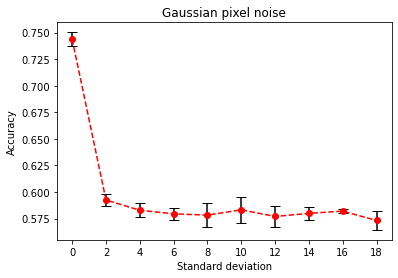

In [20]:
std_list = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
mean_accuracies_list_GPN, stds_list_GPN = run_model(std_list, saved_models)
plot_graph(std_list, mean_accuracies_list_GPN, stds_list_GPN, 'Gaussian pixel noise', 'Standard deviation', 'GPN')

## Gaussian blurring

In [26]:
class GB(CatDogDataset):
    def __init__(self, convolving_times, root_dir, set_name, transform):
        super().__init__(root_dir, set_name, transform)
        self.convolving_times = convolving_times
    
    def __getitem__(self, index):

        image_name, target = self.data[index][0], self.data[index][1]
        img = cv2.imread(self.root_dir + image_name)

#         if len(img.shape) == 2:
#             img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
            
        mask = 1/16 * np.array([[1, 2, 1],
                                [2, 4, 2],
                                [1, 2, 1]])
      
        for n in range(self.convolving_times):
            for c in range(3):
                img[:, :, c] = signal.correlate2d(img[:,:,c], mask, boundary='fill', mode='same')
                
        img = np.clip(img, 0, 255)

        return img, np.array([target])

In [70]:
convolving_list = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9]
mean_accuracies_list_GB, stds_list_GB = run_model(convolving_list, saved_models)
plot_graph(convolving_list, mean_accuracies_list_GB, stds_list_GB, 'Gaussian blurring', 'Number of convolutions', 'GB')

ValueError: object arrays are not supported

## Image contrast increase

In [28]:
class ICI(CatDogDataset):
    def __init__(self, contrast, root_dir, set_name, transform):
        super().__init__(root_dir, set_name, transform)
        self.contrast = contrast
    
    def __getitem__(self, index):

        image_name, target = self.data[index][0], self.data[index][1]
        img = cv2.imread(self.root_dir + image_name)
        
#         if len(img.shape) == 2:
#             img = np.repeat(img[:, :, np.newaxis], 3, axis=2)    
      
        img = np.rint(self.contrast * img).astype(np.uint8)
                
        img = np.clip(img, 0, 255)

#         img = Image.fromarray(img)        
#         if self.transform:
#             img = self.transform(img)

        return img, np.array([target])

Accuracy:  0.7437559676365645
Std:  0.006563702882801654
Accuracy:  0.7546296296296297
Std:  0.011456782482168486
Accuracy:  0.7403764008241621
Std:  0.004024638504286024
Accuracy:  0.7492273481079451
Std:  0.011197281280442018
Accuracy:  0.7483102165937986
Std:  0.0050974118657023315
Accuracy:  0.7537439067289814
Std:  0.0057287244627236295
Accuracy:  0.7440512086034475
Std:  0.015896235343277682
Accuracy:  0.7407156138499422
Std:  0.012604647186394306
Accuracy:  0.7356399819086387
Std:  0.02139134945163771
Accuracy:  0.7273166993316247
Std:  0.012120744694213767


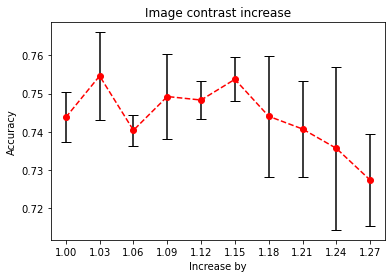

In [25]:
contrast = [1.0, 1.03, 1.06, 1.09, 1.12, 1.15, 1.18, 1.21, 1.24, 1.27]
mean_accuracies_list_ICI, stds_list_ICI = run_model(contrast, saved_models)
plot_graph(contrast, mean_accuracies_list_ICI, stds_list_ICI, 'Image contrast increase', 'Increase by', 'ICI_inc')

## Image contrast decrease

In [81]:
contrast = [1.0, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10]
mean_accuracies_list_ICD, stds_list_ICD = run_model(contrast, saved_models)
plot_graph(contrast, mean_accuracies_list_ICD, stds_list_ICD, 'Image contrast decrease', 'Decrease by', 'ICI_dec')

Accuracy:  0.7437559676365645
Std:  0.006563702882801654


ValueError: object arrays are not supported

## Image brightness increase

In [42]:
class IB(CatDogDataset):
    def __init__(self, brightness_increase, root_dir, set_name, transform):
        super().__init__(root_dir, set_name, transform)
        self.brightness_increase = brightness_increase
    
    def __getitem__(self, index):

        image_name, target = self.data[index][0], self.data[index][1]
        img = cv2.imread(self.root_dir + image_name)

#         if len(img.shape) == 2:
#             img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
            
        img = (img + self.brightness_increase).astype(np.uint8)
        img = np.clip(img, 0, 255)

#         img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)

        return img, np.array([target])

Accuracy:  0.7437559676365645
Std:  0.006563702882801654
Accuracy:  0.7441454344439419
Std:  0.004035785623820061
Accuracy:  0.7500314086134982
Std:  0.00626607743135309
Accuracy:  0.7462372481029198
Std:  0.003326603676240575
Accuracy:  0.7441454344439419
Std:  0.0028838238861041868
Accuracy:  0.7383097140559828
Std:  0.007478477276781795
Accuracy:  0.7399429619578873
Std:  0.012051839845050316
Accuracy:  0.736180210060807
Std:  0.013889404543120222
Accuracy:  0.7374365546007337
Std:  0.003789441083284523
Accuracy:  0.7420222121714658
Std:  0.007306151205104777


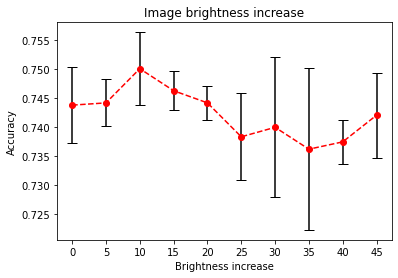

In [38]:
brightness_increase = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
mean_accuracies_list_IBI, stds_list_IBI = run_model(brightness_increase, saved_models)
plot_graph(brightness_increase, mean_accuracies_list_IBI, stds_list_IBI, 'Image brightness increase', 'Brightness increase', 'IBI_inc')

## Image brightness decrease

In [39]:
brightness_decrease = [0, -5, -10, -15, -20, -25, -30, -35, -40, -45]
mean_accuracies_list_IBD, stds_list_IBD = run_model(brightness_decrease, saved_models)
plt.errorbar(brightness_decrease, mean_accuracies_list, stds_list,
             color='red', ls='--', marker='o', capsize=5, capthick=1, ecolor='black')
plt.xticks(brightness_decrease)
plt.title('Image brightness decrease')
plt.xlim(5, -50)
plt.xlabel('Brightness decrease')
plt.ylabel('Accuracy')
plt.savefig('./robustness_graphs_BOVW/IBI_dec.pdf')   
plt.show()

Accuracy:  0.7437559676365645
Std:  0.006563702882801654


error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


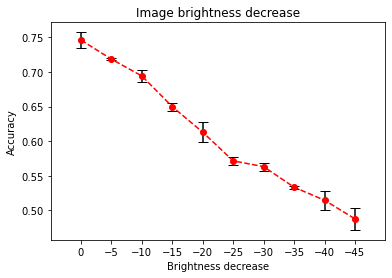

## HSV Hue noise increase

In [53]:
class HNI(CatDogDataset):
    def __init__(self, std, root_dir, set_name, transform):
        super().__init__(root_dir, set_name, transform)
        self.std = std
    
    def __getitem__(self, index):

        image_name, target = self.data[index][0], self.data[index][1]
        img = cv2.imread(self.root_dir + image_name)
        
#       if len(img.shape) == 2:
#             img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        
        img = matplotlib.colors.rgb_to_hsv(img/255)

        noise = np.random.normal(0, self.std, (224, 224))
        img[:, :, 0] = img[:, :, 0] + noise

        img[:, :, 0] = np.where(img[:, :, 0] > 1, img[:, :, 0] - 1,  img[:, :, 0])
        img[:, :, 0] = np.where(img[:, :, 0] < 0, img[:, :, 0] + 1,  img[:, :, 0])

        img = matplotlib.colors.hsv_to_rgb(img)
        img = np.rint(img * 255).astype(np.uint8)

        return img, np.array([target])

Accuracy:  0.7437559676365645
Std:  0.006563702882801654
Accuracy:  0.7424933413739384
Std:  0.01786462629497871
Accuracy:  0.7353321774963565
Std:  0.0037004892118552
Accuracy:  0.7386740539725615
Std:  0.0038445528570908005
Accuracy:  0.750288959244183
Std:  0.02568718310356118
Accuracy:  0.7515641489522086
Std:  0.019615466466635714
Accuracy:  0.7390195487210413
Std:  0.017677785581202407
Accuracy:  0.7373925825418363
Std:  0.01320118485317027
Accuracy:  0.7391137745615358
Std:  0.0044272242868208635
Accuracy:  0.7352882054374592
Std:  0.009838934547677631


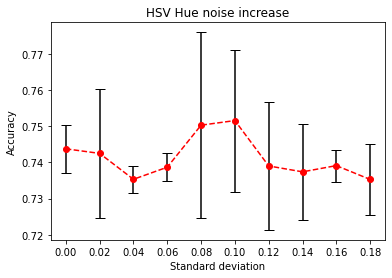

In [45]:
std_list = [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18]
mean_accuracies_list_HNI, stds_list_HNI = run_model(std_list, saved_models)
plot_graph(std_list, mean_accuracies_list_HNI, stds_list_HNI, 'HSV Hue noise increase', 'Standard deviation', 'HSV_hue')

## HSV Saturation noise increase

In [58]:
class SNI(CatDogDataset):
    def __init__(self, std, root_dir, set_name, transform):
        super().__init__(root_dir, set_name, transform)
        self.std = std
    
    def __getitem__(self, index):

        image_name, target = self.data[index][0], self.data[index][1]
        img = cv2.imread(self.root_dir + image_name)
        
#         if len(img.shape) == 2:
#             img = np.repeat(img[:, :, np.newaxis], 3, axis=2
        
        img = matplotlib.colors.rgb_to_hsv(img/255)

        noise = np.random.normal(0, self.std, (224, 224))
        img[:, :, 1] = img[:, :, 1] + noise
        
        img = np.clip(img, 0.0, 1.0)

        img = matplotlib.colors.hsv_to_rgb(img)
        img = np.rint(img * 255).astype(np.uint8)

        return img, np.array([target])

Accuracy:  0.7437559676365645
Std:  0.006563702882801654
Accuracy:  0.7487750640735715
Std:  0.005724435013161977
Accuracy:  0.7475187195336449
Std:  0.007832482018107371
Accuracy:  0.7428388361224183
Std:  0.008859454060680862
Accuracy:  0.7466518418010956
Std:  0.003173961223935979
Accuracy:  0.7449432132267954
Std:  0.0057758006388585244
Accuracy:  0.7536873712246847
Std:  0.014055164683729013
Accuracy:  0.750804060505553
Std:  0.006899347902732345
Accuracy:  0.7390509573345394
Std:  0.011021008128833084
Accuracy:  0.742399115533444
Std:  0.010964087920338067


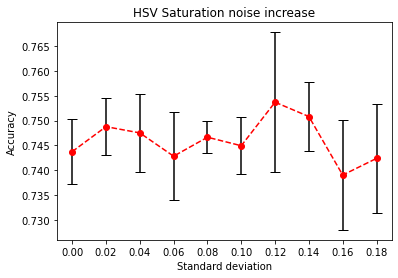

In [50]:
std_list = [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18]
mean_accuracies_list_SNI, stds_list_SNI = run_model(std_list, saved_models)
plot_graph(std_list, mean_accuracies_list_SNI, stds_list_SNI, 'HSV Saturation noise increase', 'Standard deviation', 'HSV_sat')

## Occlusion of the image increase

In [61]:
class OII(CatDogDataset):
    def __init__(self, edge_length, root_dir, set_name, transform):
        super().__init__(root_dir, set_name, transform)
        self.edge_length = edge_length
    
    def __getitem__(self, index):

        image_name, target = self.data[index][0], self.data[index][1]
        img = cv2.imread(self.root_dir + image_name)

#         if len(img.shape) == 2:
#             img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        
        # randomly choose the top-left pixel of the square region
        
        x = random.randint(0, 224-self.edge_length)
        y = random.randint(0, 224-self.edge_length)

        img[x:x+self.edge_length, y: y+self.edge_length, :] = 0

        return img, np.array([target])

Accuracy:  0.7437559676365645
Std:  0.006563702882801654
Accuracy:  0.7441705613347404
Std:  0.006255384757130292
Accuracy:  0.7450123121764912
Std:  0.007481729519887357
Accuracy:  0.7420787476757625
Std:  0.01020535598754989
Accuracy:  0.7454080607065682
Std:  0.0025650436062569816
Accuracy:  0.7299236142519724
Std:  0.00864098394341754
Accuracy:  0.7391703100658326
Std:  0.012553447200084389
Accuracy:  0.7370219609025579
Std:  0.002597718301379267
Accuracy:  0.7186165133926329
Std:  0.00750504728323941
Accuracy:  0.7282840846273682
Std:  0.018833540183694198


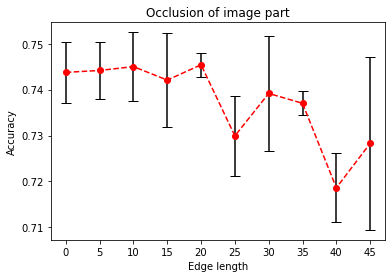

In [53]:
length_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
mean_accuracies_list_OII, stds_list_OII = run_model(length_list, saved_models)
plot_graph(length_list, mean_accuracies_list_OII, stds_list_OII, 'Occlusion of image part', 'Edge length', 'OII')

# New attempt

In [ ]:
# three-fold validation

# use different set (A, B or C) as test set
testsets = ['A', 'B', 'C']
            
all_accuracies_train_2 = []
all_accuracies_val_2 = []
all_accuracies_test_2 = []

saved_models_2 = []
# orb, stdSlr, voc, clf
for clusters in [400, 1000, 2000, 4000]:

    accuracies_train_2 = []
    accuracies_val_2 = []
    accuracies_test_2 = []
    for testset in testsets:

        descriptors_list = []
        orb_2 = cv2.ORB_create(nfeatures=1000)

        image_datasets, dataset_sizes = load_data(setname=testset)

        for image in image_datasets['train']:
            im = cv2.imread(image[0])
            kp = orb_2.detect(im,None)
            keypoints, descriptor = orb_2.compute(im, kp)
            descriptors_list.append((image,descriptor))

        # Stack all the descriptors vertically in a numpy array
        descriptors = descriptors_list[0][1]
        for image_path, descriptor in descriptors_list[1:]:
            descriptors = np.vstack((descriptors, descriptor))


        #kmeans works only on float, so convert integers to float
        descriptors_float = descriptors.astype(float) # maybe don't need

        # K-Means clustering
        # Perform k-means clustering and vector quantization

        k = clusters #240  #k means with 100 clusters gives lower accuracy for the aeroplane example 
        #     (A rule-of-thumb is to create k centers with k = number of categories * 10)
        # https://www.kaggle.com/pierre54/bag-of-words-model-with-sift-descriptors
        voc_2, variance = kmeans(descriptors_float, k, 1)
    #         kmeans = KMeans(n_clusters=k).fit(descriptors_float)
        print('**********')
        print('Clusters: ', clusters)
        # Calculate the histogram of features and represent them as vector
        #vq Assigns codes from a code book to observations.
        im_features = np.zeros((len(image_datasets['train']), k), "float32")
        for i in range(len(image_datasets['train'])):
            words, distance = vq(descriptors_list[i][1], voc_2)
            for w in words:
                im_features[i][w] += 1


        # Get target class labels
        image_classes_train = [x[1][0] for x in image_datasets['train']]
        image_classes_train = np.array(image_classes_train)


        # Perform Tf-Idf vectorization (why do I need this?)
#         nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
#         idf = np.array(np.log((1.0*len(image_datasets['train'])+1) / (1.0*nbr_occurences + 1)), 'float32')


        # Scaling the words
        #Standardize features by removing the mean and scaling to unit variance
        #In a way normalization

        stdSlr_2 = StandardScaler().fit(im_features)
        im_features = stdSlr_2.transform(im_features)


        #Train an algorithm to discriminate vectors corresponding to positive and negative training images
        # Train the Linear SVM
        clf_2 = SVC(kernel='rbf')
        clf_2.fit(im_features, np.array(image_classes_train))

        true_classes_train=[]
        for i in image_classes_train:
            if i==0:
                true_classes_train.append("Cat")
            else:
                true_classes_train.append("Dog")

        predict_classes_train=[]
        for i in clf_2.predict(im_features):
            if i==0:
                predict_classes_train.append("Cat")
            else:
                predict_classes_train.append("Dog")

        accuracy_train_2 = accuracy_score(true_classes_train, predict_classes_train)
        accuracies_train_2.append(accuracy_train_2)
        
        print('Accuracy train, set ', testset, ': ', accuracy_train_2)

        """
        Validation
        """

        image_classes_val = [x[1][0] for x in image_datasets['val']]
        image_classes_val = np.array(image_classes_val)

        description_list_val=[]

        for image in image_datasets['val']:
            im = cv2.imread(image[0])
            kp = orb_2.detect(im,None)
            keypoints_test, descriptor_val = orb_2.compute(im, kp)
            description_list_val.append((image,descriptor_val)) # why not image[0]


        test_features = np.zeros((len(image_datasets['val']),k),"float32")
        for i in range(len(image_datasets['val'])):
            words, distance = vq(description_list_val[i][1], voc_2)
            for w in words:
                test_features[i][w] += 1

        test_features = stdSlr_2.transform(test_features)

        true_classes_val=[]
        for i in image_classes_val:
            if i==0:
                true_classes_val.append("Cat")
            else:
                true_classes_val.append("Dog")

        predict_classes_val=[]
        for i in clf_2.predict(test_features):
            if i==0:
                predict_classes_val.append("Cat")
            else:
                predict_classes_val.append("Dog")

        accuracy_val_2 = accuracy_score(true_classes_val, predict_classes_val)
        accuracies_val_2.append(accuracy_val_2)

        print('Accuracy validation, set ', testset, ': ', accuracy_val_2)
        
        """
        Test
        """

        image_classes_test = [x[1][0] for x in image_datasets['test']]
        image_classes_test = np.array(image_classes_test)

        description_list_test = []

        for image in image_datasets['test']:
            im = cv2.imread(image[0])
            kp = orb_2.detect(im,None)
            keypoints_test, descriptor_test = orb_2.compute(im, kp)
            description_list_test.append((image, descriptor_test)) # why not image[0]


        test_features = np.zeros((len(image_datasets['test']), k),"float32")
        for i in range(len(image_datasets['test'])):
            words, distance = vq(description_list_test[i][1], voc_2)
            for w in words:
                test_features[i][w] += 1

        test_features = stdSlr_2.transform(test_features)

        true_classes_test = []
        for i in image_classes_test:
            if i==0:
                true_classes_test.append("Cat")
            else:
                true_classes_test.append("Dog")

        predict_classes_test=[]
        for i in clf_2.predict(test_features):
            if i==0:
                predict_classes_test.append("Cat")
            else:
                predict_classes_test.append("Dog")

        accuracy_test_2 = accuracy_score(true_classes_test, predict_classes_test)
        accuracies_test_2.append(accuracy_test_2)
        
        print('Accuracy test, set ', testset, ': ', accuracy_test_2)
        
        saved_model_2 = [orb_2, stdSlr_2, voc_2, clf_2]
        saved_models_2.append(saved_model)
    
    all_accuracies_train_2.append(np.mean(accuracies_train_2))
    all_accuracies_val_2.append(np.mean(accuracies_val_2))
    all_accuracies_test_2.append(np.mean(accuracies_test_2))

**********
Clusters:  400
Accuracy train, set  A :  0.94
Accuracy validation, set  A :  0.7575757575757576
Accuracy test, set  A :  0.7424242424242424
**********
Clusters:  400
Accuracy train, set  B :  0.95
Accuracy validation, set  B :  0.7803030303030303
Accuracy test, set  B :  0.7462121212121212
**********
Clusters:  400
Accuracy train, set  C :  0.9358333333333333
Accuracy validation, set  C :  0.7526041666666666
Accuracy test, set  C :  0.7425373134328358
**********
Clusters:  1000
Accuracy train, set  A :  0.9725
Accuracy validation, set  A :  0.7853535353535354
Accuracy test, set  A :  0.75
**********
Clusters:  1000
Accuracy train, set  B :  0.9675
Accuracy validation, set  B :  0.7727272727272727
Accuracy test, set  B :  0.7361111111111112
**********
Clusters:  1000
Accuracy train, set  C :  0.9566666666666667
Accuracy validation, set  C :  0.7265625
Accuracy test, set  C :  0.722636815920398
